In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn import datasets

crime_2015 = pd.read_csv('CSVs/CrimeData-2015.csv')
crime_2018 = pd.read_csv('CSVs/CrimeData-2018.csv')
pdx_walk_df = pd.read_csv('CSVs/PDX_Neighborhood_Walkability.csv')
zip_walk_df = pd.read_csv('CSVs/zip_import.csv')

crime_2015 = crime_2015.loc[crime_2015['Neighborhood'].isnull() == False]
crime_2018 = crime_2018.loc[crime_2018['Neighborhood'].isnull() == False]

gcrime_2015 = crime_2015.groupby(['Neighborhood']).size().reset_index(name='OffenseCount2015')
gcrime_2018 = crime_2018.groupby(['Neighborhood']).size().reset_index(name='OffenseCount2018')

ccrime_df = pd.merge(gcrime_2015, gcrime_2018, how='inner', on='Neighborhood')

ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'Old Town/Chinatown'].index, 0] = 'Old Town Chinatown'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'Lloyd'].index, 0] = 'Lloyd District'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'Mt Scott-Arleta'].index, 0] = 'Mt. Scott-Arleta'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'Mt Tabor'].index, 0] = 'Mt. Tabor'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'St Johns'].index, 0] = 'St. Johns'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'] == 'Northwest'].index, 0] = 'Northwest District'
ccrime_df.iloc[ccrime_df.loc[ccrime_df['Neighborhood'].str.contains('Buckman')].index, 0] = 'Buckman'

pdx_crime_df = pd.merge(ccrime_df, pdx_walk_df, how='outer', left_on='Neighborhood', right_on='Name')
cc_walk_df = pdx_crime_df.loc[(pdx_crime_df['Name'].isnull() == False)][['Name', 'Population', 'OffenseCount2015', 'OffenseCount2018']]

cc_vs_walk = pd.merge(cc_walk_df, zip_walk_df, how='outer', left_on='Name', right_on='name')
cc_vs_walk = cc_vs_walk[['Name', 'Walk Score', 'OffenseCount2015', 'OffenseCount2018', 'Population', 'lat', 'lng', 'Zipcode']]

cc_vs_walk = cc_vs_walk.loc[cc_vs_walk['Zipcode'].isnull() == False].reset_index(drop=True)
cc_vs_walk['Zipcode'] = cc_vs_walk['Zipcode'].astype(int)
cc_vs_walk['Walk Score'] = cc_vs_walk['Walk Score'].astype(int)

cc_vs_walk

,Name,Walk Score,OffenseCount2015,OffenseCount2018,Population,lat,lng,Zipcode
0,Alameda,65,102,168,"5,206",45.544656,-122.626080,97212
1,Arbor Lodge,77,319,465,"6,131",45.577213,-122.678591,97217
2,Arlington Heights,35,66,73,784,45.516569,-122.699493,97201
3,Arnold Creek,21,22,25,"2,850",45.439449,-122.707645,97035
4,Ashcreek,36,53,98,"5,705",45.467338,-122.748808,97223
...,...,...,...,...,...,...,...,...
67,University Park,53,215,260,"5,996",45.574956,-122.707959,97217
68,Vernon,88,92,177,"2,630",45.557687,-122.642908,97211
69,West Portland Park,57,68,185,"3,923",45.440351,-122.727222,97219
70,Wilkes,31,325,543,"8,768",45.533852,-122.625361,97232


In [15]:
# Write to csv
file = open('CSVs/crime_vs_walkscore.csv', 'w')
file.truncate()
file.close()

cc_vs_walk.to_csv('CSVs/crime_vs_walkscore.csv', index=False, header=True)

Text(7, 1137, 'r=0.31')

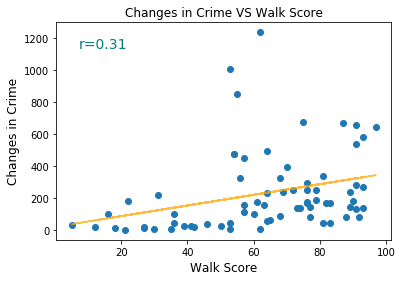

In [73]:
cvw = pd.read_csv('CSVs/crime_vs_walkscore.csv')

cvw['Change in Crime'] = pd.DataFrame(cvw['OffenseCount2018'] - cvw['OffenseCount2015'])
crime_walk_df = cvw.drop(columns=['Name', 'OffenseCount2015', 'OffenseCount2018', 'Population', 'lat', 'lng'])

crime_walk_df.sort_values(by='Walk Score')

x_values = crime_walk_df['Walk Score']
y_values = crime_walk_df['Change in Crime']

plt.scatter(x_values, y_values)
plt.xlabel('Walk Score', fontsize=12.0)
plt.ylabel('Changes in Crime', fontsize=12.0)
plt.title('Changes in Crime VS Walk Score')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
plt.plot(x_values, regress_values, color='orange', linestyle='solid', alpha=.75)
plt.annotate(f'r={round(rvalue, 2)}', (x_values.min()+2, y_values.max()-100), fontsize=14,color='teal')

In [91]:
income_by_nh = pd.read_csv('CSVs/income_by_neighborhood.csv')
join_income = income_by_nh[['name', 'Median Income 2012', 'Median Income 2018']]
join_income['Change in Income'] = pd.DataFrame(join_income['Median Income 2018'] - join_income['Median Income 2012'])

crime_vs_income = pd.merge(cc_vs_walk, join_income, how='left', left_on='Name', right_on='name')
crime_walk_df

C:\Users\Rahil\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Walk Score,Zipcode,Change in Crime
0,65,97212,66
1,77,97217,146
2,35,97201,7
3,21,97035,3
4,36,97223,45
...,...,...,...
67,53,97217,45
68,88,97211,85
69,57,97219,117
70,31,97232,218
